In [2]:
%load_ext autoreload

%autoreload 2
%matplotlib inline

import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import numpy as np
import pytz
import pandas as pd

from analysis import get_ticker_history, get_etfs_history, History

MOSCOW_TIMEZONE = pytz.timezone('Europe/Moscow')

# From rest
# client = openapi.sandbox_api_client(token)
# client.sandbox.sandbox_register_post()
# client.sandbox.sandbox_clear_post()
# client.sandbox.sandbox_currencies_balance_post(sandbox_set_currency_balance_request={"currency": "USD", "balance": 1000})


# From streaming
# candle_subs = [{'figi': 'BBG000B9XRY4', 'interval': '1min'}, {'figi': 'BBG009S39JX6', 'interval': '1min'}]
# orderbook_subs = [{'figi': 'BBG0013HGFT4', 'depth': 1}, {'figi': 'BBG009S39JX6', 'depth': 3}]
# instrument_info_subs = [{'figi': 'BBG000B9XRY4'}, {'figi': 'BBG009S39JX6'}]

# run_stream_consumer(token,
#                     candle_subs, orderbook_subs, instrument_info_subs,
#                     on_candle_event=print_event,
#                     on_orderbook_event=print_event,
#                     on_instrument_info_event=print_event)



In [3]:
end = dt.datetime.now(dt.timezone.utc)
start = end - dt.timedelta(weeks=52)
interval = 'day'
ticker='FXGD'

# print(etfs)


# print(market.market_candles_get(figi=figi, _from=start.isoformat(), to=end.isoformat(), interval=interval))
# ['payload']['instruments'][0]['figi']

ticker_history = get_ticker_history(ticker=ticker, start=start, end=end, interval=interval)

Text(0.5, 1.0, 'FXGD')

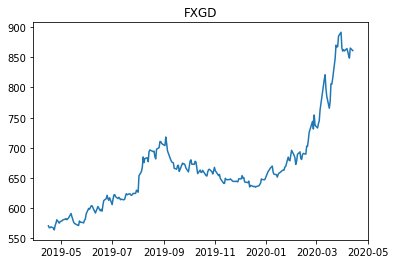

In [4]:
plt.figure()
plt.plot(ticker_history['time'].values, ticker_history['c'])
plt.title(ticker)

In [5]:
etfs_history, etf_tickers = get_etfs_history()

## Try to correctly download and store history

In [7]:
hist_daily = History(interval='day')
# display(hist_daily.data.time.dtype)
hist_daily.update(reload=0)
hist_daily.data

Getting forecast with interval=day:   0%|          | 0/1 [00:00<?, ?it/s]

Local history data loaded successfully


Getting forecast with interval=day: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


History data updated successfully!


,FXGD_figi,FXGD_o,FXGD_c,FXGD_h,FXGD_l,FXGD_v,time,FXCN_figi,FXCN_o,FXCN_c,...,FXRW_c,FXRW_h,FXRW_l,FXRW_v,FXWO_figi,FXWO_o,FXWO_c,FXWO_h,FXWO_l,FXWO_v
0,NaN,NaN,NaN,NaN,NaN,NaN,2013-04-30 07:00:00+00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-03 07:00:00+00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-06 07:00:00+00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-07 07:00:00+00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-08 07:00:00+00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,BBG005DXDPK9,862.0,859.4,868.8,852.0,210438.0,2020-04-07 07:00:00+00:00,BBG005VKB7D7,3004.0,3020.0,...,0.8350,0.8599,0.8200,17923706.0,BBG00R9805F5,1.2451,1.2580,1.2752,1.2405,2637549.0
1720,BBG005DXDPK9,860.0,853.4,861.6,852.0,47283.0,2020-04-08 07:00:00+00:00,BBG005VKB7D7,3028.0,2990.0,...,0.8318,0.8400,0.8200,3152618.0,BBG00R9805F5,1.2696,1.2500,1.2696,1.2357,1266504.0
1721,BBG005DXDPK9,852.6,848.6,854.0,832.0,190900.0,2020-04-09 07:00:00+00:00,BBG005VKB7D7,2990.0,2940.0,...,0.8393,0.8449,0.8100,10234467.0,BBG00R9805F5,1.2549,1.2441,1.2900,1.2300,1841123.0
1722,BBG005DXDPK9,852.8,865.2,868.0,849.4,93976.0,2020-04-10 07:00:00+00:00,BBG005VKB7D7,2908.0,2966.0,...,0.8697,0.8720,0.8150,5272415.0,BBG00R9805F5,1.2348,1.2653,1.2710,1.2348,1680137.0


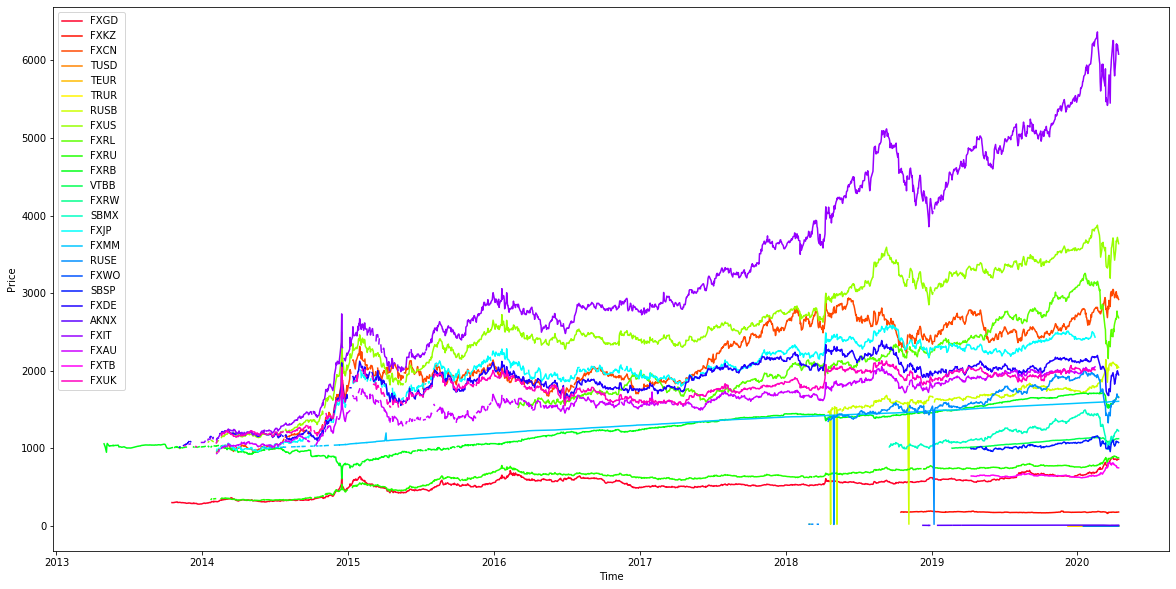

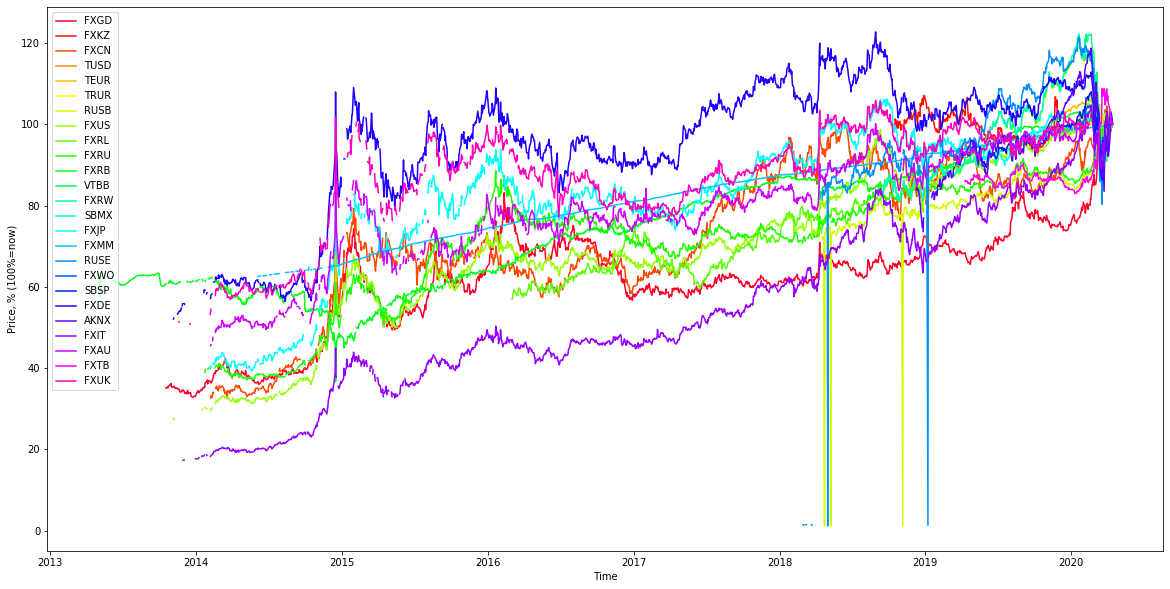

In [8]:
data = hist_daily.data
tickers = hist_daily.tickers
# print(data['time'].dtype)

M = len(hist_daily.tickers)
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=M-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

def get_last_not_nan(lst):
    for el in lst[::-1]:
        if not np.isnan(el):
            return el
        
    return np.nan


plt.figure(figsize = (20,10))
ax = plt.gca()
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(M)])
for ticker in tickers:
    t = data['time'].values
    y = data[ticker+'_c'] # / get_last_not_nan(data[ticker+'_c']) * 100
    plt.plot(t, y, label=ticker)
    
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()

plt.figure(figsize = (20,10))
ax = plt.gca()
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(M)])
for ticker in tickers:
    t = data['time'].values
    y = data[ticker+'_c'] / get_last_not_nan(data[ticker+'_c']) * 100
    plt.plot(t, y, label=ticker)
    
plt.ylabel('Price, % (100%=now)')
plt.xlabel('Time')
plt.legend()